In [3]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [4]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "preprocessed/{0}/florida_processed_{0}.csv"
COUPLES_PATH="couples/{0}/couples_{0}.csv"

In [5]:
preprocessed_date = '20150323'

In [6]:
couples_date = '20140319'

In [7]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
global_df.isnull().sum()

county_code                     0
voter_id                        0
last_name                     136
first_name                    455
residence_addr_line_1           0
residence_addr_line_2    10499701
residence_city                  0
residence_zipcode               0
gender                          0
race                          207
birth_date                      0
registration_date               0
party_affiliation               0
precinct                        0
voter_status                    0
age                             0
residence_zipcode_5             0
residence_zipcode_4      11745698
uniq_addr                       0
dtype: int64

In [9]:
global_df.head()


,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr
0,ALA,100384084,beard,janet,4018 nw 18th pl,NaN,gainesville,326053525,F,5.0,10/12/1952,06/15/1976,DEM,24,ACT,62,32605,3525.0,4018 nw 18th pl gainesville 32605
1,ALA,100384085,beardsley,gene,4416 nw 93rd ave,NaN,gainesville,32653,F,5.0,08/14/1933,10/05/1967,DEM,45,ACT,81,32653,NaN,4416 nw 93rd ave gainesville 32653
2,ALA,100384086,beardsley,richard,4416 nw 93rd ave,NaN,gainesville,32653,M,5.0,11/07/1933,10/05/1967,GRE,45,ACT,81,32653,NaN,4416 nw 93rd ave gainesville 32653
3,ALA,100384090,beauchamp,gayla,4633 nw 35th rd,NaN,gainesville,32606,F,5.0,09/11/1942,02/25/1978,REP,22,ACT,72,32606,NaN,4633 nw 35th rd gainesville 32606
4,ALA,100384092,beazlie,annetta,4237 nw 13th st,NaN,gainesville,32609,F,5.0,05/18/1929,08/09/1958,DEM,55,ACT,85,32609,NaN,4237 nw 13th st gainesville 32609


In [10]:
req_cols = ['last_name', 'race', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [11]:
global_df.isnull().sum()

county_code                     0
voter_id                        0
last_name                       0
first_name                      0
residence_addr_line_1           0
residence_addr_line_2    10499044
residence_city                  0
residence_zipcode               0
gender                          0
race                            0
birth_date                      0
registration_date               0
party_affiliation               0
precinct                        0
voter_status                    0
age                             0
residence_zipcode_5             0
residence_zipcode_4      11744955
uniq_addr                       0
dtype: int64

In [12]:
global_df.shape

(12858935, 19)

In [13]:
global_df.county_code.unique()

array(['ALA', 'BAK', 'BAY', 'BRA', 'BRE', 'BRO', 'CAL', 'CHA', 'CIT',
       'CLA', 'CLL', 'CLM', 'DAD', 'DES', 'DIX', 'DUV', 'ESC', 'FLA',
       'FRA', 'GAD', 'GIL', 'GLA', 'GUL', 'HAM', 'HAR', 'HEN', 'HER',
       'HIG', 'HIL', 'HOL', 'IND', 'JAC', 'JEF', 'LAF', 'LAK', 'LEE',
       'LEO', 'LEV', 'LIB', 'MAD', 'MAN', 'MON', 'MRN', 'MRT', 'NAS',
       'OKA', 'OKE', 'ORA', 'OSC', 'PAL', 'PAS', 'PIN', 'POL', 'PUT',
       'SAN', 'SAR', 'SEM', 'STJ', 'STL', 'SUM', 'SUW', 'TAY', 'UNI',
       'VOL', 'WAK', 'WAL', 'WAS'], dtype=object)

In [14]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
couples_df.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,race_R,birth_date_R,registration_date_R,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff
0,CLA,111224731,clegg,bonnie,1 clay county,NaN,grn cv spgs,32043,F,5.0,...,5.0,04/24/1951,03/29/2006,REP,606,ACT,62,32043,NaN,0
1,CLA,102846326,champion,elizabeth,4923 adra ct,NaN,fleming island,320037873,F,5.0,...,5.0,08/08/1956,02/06/1988,REP,414,ACT,57,32003,7873.0,0
2,CLA,102846332,rund,matthew,2332 birdwood dr,NaN,orange park,320735324,M,5.0,...,5.0,01/29/1934,02/04/1988,REP,210,ACT,80,32073,5324.0,0
3,CLA,102846804,de gidio,valrae,3016 alpaca ave,NaN,middleburg,320686413,F,5.0,...,5.0,08/12/1942,06/07/1999,REP,508,ACT,71,32068,6413.0,0
4,CLA,102840283,pike,anna,6653 immokalee rd,NaN,keystone heights,326568990,F,5.0,...,5.0,08/07/1940,03/16/1984,REP,702,ACT,73,32656,8990.0,0


In [16]:
addr_df=global_df[['uniq_addr','voter_id']] 

In [17]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["voter_id_L"], right_on=["voter_id"], suffixes=["","_L"])

In [18]:
del couples_df_found['voter_id']

In [19]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["voter_id_R"], right_on=["voter_id"], suffixes=["","_R"])

In [20]:
del couples_df_found['voter_id']

In [21]:
couples_df_found[["voter_id_L","voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,voter_id_L,voter_id_R,uniq_addr_L,uniq_addr_R
0,111224731,114194885,1 clay county grn cv spgs 32043,1 clay county grn cv spgs 32043
1,102846326,102848834,4923 adra ct fleming island 32003,4923 adra ct fleming island 32003
2,102846332,102848464,2332 birdwood dr orange park 32073,2332 birdwood dr orange park 32073
3,102846804,102933269,3016 alpaca ave middleburg 32068,3016 alpaca ave middleburg 32068
4,102840283,102841076,6653 immokalee rd keystone heights 32656,6653 immokalee rd keystone heights 32656


In [22]:
couples_df_found['uniq_addr_L'].equals(couples_df_found['uniq_addr_R'])

False

In [23]:
c=couples_df_found.loc[couples_df_found.voter_id_L==111224731]
print(c.uniq_addr_L!=c.uniq_addr_R)

0    False
dtype: bool


In [24]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

In [25]:
couples_df_found['separated'].value_counts()

False    2604139
True      179480
Name: separated, dtype: int64

In [26]:
couples_df_found.isnull().sum()

county_code_L                    0
voter_id_L                       0
last_name_L                      0
first_name_L                     0
residence_addr_line_1_L          0
residence_addr_line_2_L    2507331
residence_city_L                 0
residence_zipcode_L              0
gender_L                         0
race_L                           9
birth_date_L                     0
registration_date_L              0
party_affiliation_L              0
precinct_L                       0
voter_status_L                   0
age_L                            0
residence_zipcode_5_L            0
residence_zipcode_4_L      2504686
uniq_addr                        0
county_code_R                    0
voter_id_R                       0
last_name_R                      1
first_name_R                     1
residence_addr_line_1_R          0
residence_addr_line_2_R    2507329
residence_city_R                 0
residence_zipcode_R              0
gender_R                         0
race_R              

In [27]:
couples_df_found.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff,uniq_addr_L,uniq_addr_R,separated
0,CLA,111224731,clegg,bonnie,1 clay county,NaN,grn cv spgs,32043,F,5.0,...,REP,606,ACT,62,32043,NaN,0,1 clay county grn cv spgs 32043,1 clay county grn cv spgs 32043,False
1,CLA,102846326,champion,elizabeth,4923 adra ct,NaN,fleming island,320037873,F,5.0,...,REP,414,ACT,57,32003,7873.0,0,4923 adra ct fleming island 32003,4923 adra ct fleming island 32003,False
2,CLA,102846332,rund,matthew,2332 birdwood dr,NaN,orange park,320735324,M,5.0,...,REP,210,ACT,80,32073,5324.0,0,2332 birdwood dr orange park 32073,2332 birdwood dr orange park 32073,False
3,CLA,102846804,de gidio,valrae,3016 alpaca ave,NaN,middleburg,320686413,F,5.0,...,REP,508,ACT,71,32068,6413.0,0,3016 alpaca ave middleburg 32068,3016 alpaca ave middleburg 32068,False
4,CLA,102840283,pike,anna,6653 immokalee rd,NaN,keystone heights,326568990,F,5.0,...,REP,702,ACT,73,32656,8990.0,0,6653 immokalee rd keystone heights 32656,6653 immokalee rd keystone heights 32656,False


In [30]:
global_df["party_affiliation"].unique()

array(['DEM', 'GRE', 'REP', 'NPA', 'REF', 'INT', 'IDP', 'LPF', 'ECO',
       'TPF', 'PSL', 'AIP', 'FSW', 'CPF', 'JPF', 'PFP'], dtype=object)

In [34]:
cols = ["party_affiliation", "gender", "race"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

In [ ]:
unique_dic

In [47]:
from itertools import combinations
total_separated = couples_df_found[couples_df_found["separated"] == True].shape[0]
stats = {}
for c in cols:
    cat_combinations = list(combinations(list(unique_dic[c]), 2))
    stats[c] = {}
    print("Processing : " + c + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[c + "_L"] == first_val) & (couples_df_found[c + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[c + "_L"] == second_val) & (couples_df_found[c + "_R"] == first_val)]
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        stats[c][first_val + "_" + second_val] = count
        i += 1
        print("Done with comb: " + str(i))
    print("Done with processing column: " + c)
        

Processing : party_affiliation : Total comb: 120
Done with comb: 1
Done with comb: 2
Done with comb: 3
Done with comb: 4
Done with comb: 5
Done with comb: 6
Done with comb: 7
Done with comb: 8
Done with comb: 9
Done with comb: 10
Done with comb: 11
Done with comb: 12
Done with comb: 13
Done with comb: 14
Done with comb: 15
Done with comb: 16
Done with comb: 17
Done with comb: 18
Done with comb: 19
Done with comb: 20
Done with comb: 21
Done with comb: 22
Done with comb: 23
Done with comb: 24
Done with comb: 25
Done with comb: 26
Done with comb: 27
Done with comb: 28
Done with comb: 29
Done with comb: 30
Done with comb: 31
Done with comb: 32
Done with comb: 33
Done with comb: 34
Done with comb: 35
Done with comb: 36
Done with comb: 37
Done with comb: 38
Done with comb: 39
Done with comb: 40
Done with comb: 41
Done with comb: 42
Done with comb: 43
Done with comb: 44
Done with comb: 45
Done with comb: 46
Done with comb: 47
Done with comb: 48
Done with comb: 49
Done with comb: 50
Done with 

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [48]:
stats

{'party_affiliation': {'PSL_REF': 0,
  'PSL_AIP': 0,
  'PSL_ECO': 0,
  'PSL_CPF': 0,
  'PSL_TPF': 0,
  'PSL_LPF': 0,
  'PSL_PFP': 0,
  'PSL_INT': 0,
  'PSL_GRE': 0,
  'PSL_JPF': 0,
  'PSL_FSW': 0,
  'PSL_REP': 0,
  'PSL_NPA': 1,
  'PSL_DEM': 1,
  'PSL_IDP': 0,
  'REF_AIP': 0,
  'REF_ECO': 0,
  'REF_CPF': 0,
  'REF_TPF': 0,
  'REF_LPF': 0,
  'REF_PFP': 0,
  'REF_INT': 0,
  'REF_GRE': 0,
  'REF_JPF': 0,
  'REF_FSW': 0,
  'REF_REP': 25,
  'REF_NPA': 20,
  'REF_DEM': 16,
  'REF_IDP': 0,
  'AIP_ECO': 0,
  'AIP_CPF': 0,
  'AIP_TPF': 0,
  'AIP_LPF': 1,
  'AIP_PFP': 0,
  'AIP_INT': 1,
  'AIP_GRE': 0,
  'AIP_JPF': 0,
  'AIP_FSW': 0,
  'AIP_REP': 7,
  'AIP_NPA': 3,
  'AIP_DEM': 5,
  'AIP_IDP': 0,
  'ECO_CPF': 0,
  'ECO_TPF': 0,
  'ECO_LPF': 0,
  'ECO_PFP': 0,
  'ECO_INT': 0,
  'ECO_GRE': 0,
  'ECO_JPF': 0,
  'ECO_FSW': 0,
  'ECO_REP': 2,
  'ECO_NPA': 2,
  'ECO_DEM': 7,
  'ECO_IDP': 0,
  'CPF_TPF': 0,
  'CPF_LPF': 0,
  'CPF_PFP': 0,
  'CPF_INT': 1,
  'CPF_GRE': 0,
  'CPF_JPF': 0,
  'CPF_FSW': 0,


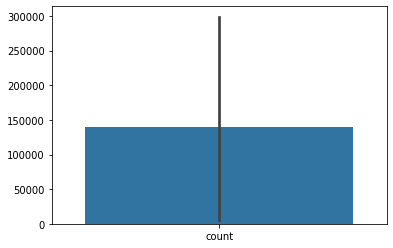

In [90]:
figs, axes = plt.subplots(nrows=1, ncols=1)
sns.barplot(data=couples_df_found.groupby(['party_affiliation_L'])['separated'].agg(['count']).reset_index())

In [30]:
]

0          421  nw 150th st  miami 33168
1        11041  sw 124th st  miami 33176
2    11047  nw 3rd ter  sweetwater 33172
3         15605  sw 57th ln  miami 33193
4        10951  sw 161st pl  miami 33196
Name: uniq_addr, dtype: object

In [32]:
global_df['voter_id'].unique().shape

(1367975,)

In [35]:
merge = pd.merge(global_df, global_df_copy, on=["uniq_addr"], suffixes=["_L", "_R"])

In [36]:
merge = merge[merge["voter_id_L"] != merge["voter_id_R"]]

In [37]:
merge.shape

(16698628, 39)

In [38]:
filtered = merge[merge["voter_id_L"] < merge["voter_id_R"]]

In [39]:
filtered.shape

(8349314, 39)

In [54]:
def modified_couple_heuristic(row):
    male_age_threshold = 27
    female_age_threshold = 25
    unknown_age_threshold = 26
    age_diff_threshold = 15
    
    age_diff = abs(row['age_L'] - row['age_R'])
    
    is_age_threshold_L = False
    if row["gender_L"] == "M" and row["age_L"] >= male_age_threshold: 
        is_age_threshold_L = True
    elif row["gender_L"] == "F" and row["age_L"] >= female_age_threshold:
        is_age_threshold_L = True
    elif row["gender_L"] == "U" and row["age_L"] >= unknown_age_threshold:
        is_age_threshold_L = True

    
        
    is_age_threshold_R = False
    if row["gender_R"] == "M" and row["age_R"] >= male_age_threshold: 
        is_age_threshold_R = True
    elif row["gender_R"] == "F" and row["age_R"] >= female_age_threshold:
        is_age_threshold_R = True
    elif row["gender_R"] == "U" and row["age_R"] >= unknown_age_threshold:
        is_age_threshold_R = True
    
    return is_age_threshold_L and is_age_threshold_R and age_diff <= age_diff_threshold
        

In [55]:
couples = filtered[filtered.apply(modified_couple_heuristic, axis=1)]

In [56]:
couples.shape

(3851206, 39)

#### https://datascience.stackexchange.com/questions/26308/after-grouping-to-minimum-value-in-pandas-how-to-display-the-matching-row-resul
#### https://jamesrledoux.com/code/drop_duplicates

In [76]:
couples["age_diff"] = couples.apply(lambda row: abs(row["age_L"] - row["age_R"]), axis=1)

/home/rahullachh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
sorted_couples = couples.sort_values(by="age_diff")

In [82]:
single_house_couples = sorted_couples.drop_duplicates(subset="uniq_addr", keep="first")

In [85]:
single_house_couples.to_csv("dad_20190813_couples.csv", sep="\t")

In [86]:
import sys
sys.getsizeof(single_house_couples)

494614416

In [60]:
agg_couples = couples.groupby(["uniq_addr"]).agg(["count"]).reset_index()

In [68]:
agg_couples.shape

(268199, 39)

In [63]:
agg_couples.columns = [' '.join(col).strip() for col in agg_couples.columns.values]

In [67]:
agg_couples[agg_couples["county_code_L count"] > 1].shape

(70130, 39)

In [69]:
consider_address = agg_couples[agg_couples["county_code_L count"] == 1]

In [73]:
a = pd.merge(couples, consider_address["uniq_addr"], on=["uniq_addr"])

In [74]:
a.columns

Index(['county_code_L', 'voter_id_L', 'last_name_L', 'first_name_L',
       'residence_addr_line_1_L', 'residence_addr_line_2_L',
       'residence_city_L', 'residence_zipcode_L', 'gender_L', 'race_L',
       'birth_date_L', 'registration_date_L', 'party_affiliation_L',
       'precinct_L', 'voter_status_L', 'age_L', 'residence_zipcode_5_L',
       'residence_zipcode_4_L', 'uniq_addr', 'first_L', 'county_code_R',
       'voter_id_R', 'last_name_R', 'first_name_R', 'residence_addr_line_1_R',
       'residence_addr_line_2_R', 'residence_city_R', 'residence_zipcode_R',
       'gender_R', 'race_R', 'birth_date_R', 'registration_date_R',
       'party_affiliation_R', 'precinct_R', 'voter_status_R', 'age_R',
       'residence_zipcode_5_R', 'residence_zipcode_4_R', 'first_R'],
      dtype='object')

In [206]:
merge[merge["voter_id_R"] == 100012467][["last_name_L", "last_name_R"]]

,last_name_L,last_name_R
2,pitambersingh,brummitt


In [205]:
merge[merge["voter_id_L"] == 100012467][["last_name_L", "last_name_R"]]

,last_name_L,last_name_R
1,brummitt,pitambersingh


In [192]:
global_df['new_uniq'] = global_df['uniq_addr'].astype('str') 

In [193]:
global_df.dtypes

county_code               object
voter_id                   int64
last_name                 object
first_name                object
residence_addr_line_1     object
residence_addr_line_2     object
residence_city            object
residence_zipcode         object
gender                    object
race                       int64
birth_date                object
registration_date         object
party_affiliation         object
precinct                 float64
voter_status              object
age                        int64
residence_zipcode_5        int64
residence_zipcode_4       object
uniq_addr                 object
member_count               int64
first                      int64
new_uniq                  object
dtype: object

In [184]:
merge[["uniq_addr", "first_name_L", "first_name_R", "last_name_L", "last_name_R", "voter_id_L", "voter_id_R", "first_L", "first_R"]].head()

,uniq_addr,first_name_L,first_name_R,last_name_L,last_name_R,voter_id_L,voter_id_R,first_L,first_R
1,421 nw 150th st miami 33168,marilyn,marilyn,brummitt,pitambersingh,100012467,110228300,1,0
2,421 nw 150th st miami 33168,marilyn,marilyn,pitambersingh,brummitt,110228300,100012467,1,0
5,11041 sw 124th st miami 33176,erna,joseph,westervelt,schmidt,100014823,108920322,1,0
6,11041 sw 124th st miami 33176,erna,aimee,westervelt,schmidt,100014823,109817781,1,0
7,11041 sw 124th st miami 33176,erna,mary,westervelt,schmidt,100014823,109896942,1,0


In [181]:
filtered = merge[(merge["first_L"] == 1) & (merge["first_R"] == 0)]

In [182]:
merge.shape

(16698628, 41)

In [183]:
filtered.shape

(16698628, 41)

In [156]:
merge = merge[merge[""]]

(18066603, 41)

In [111]:
global_df = pd.merge(global_df, global_df2, on=['uniq_addr'], how='inner')

KeyboardInterrupt: 

In [112]:
global_df = pd.merge(global_df, aggregated_df, on=['uniq_addr', 'last_name'], how='inner')

In [136]:
aggregated_df.head()

,uniq_addr,last_name,county_code count,voter_id count,first_name count,residence_addr_line_1 count,residence_addr_line_2 count,residence_city count,residence_zipcode count,gender count,race count,birth_date count,registration_date count,party_affiliation count,precinct count,voter_status count,age count,residence_zipcode_5 count,residence_zipcode_4 count,member_count count
0,1 adams ky islandia 33035,stephens,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1 alhambra cir coral gables 33134,calvillo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1 alhambra cir 205 coral gables 33134,yngerto,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1 alhambra cir 302 coral gables 33134,menendez palacios,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1 alhambra cir 303 coral gables 33134,morales,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [62]:
aggregated_df[aggregated_df[] > 1].head()

KeyError: 'county_code count'

In [114]:
house_size_2 = global_df[global_df['member_count'] == 2]

In [115]:
male_df = house_size_2[house_size_2['gender'] == 'M']

In [116]:
female_df = house_size_2[house_size_2['gender'] == 'F']

In [117]:
temp = pd.merge(male_df, female_df, on=['uniq_addr', 'last_name'], how='inner', suffixes=('_male', '_female'))

In [118]:
lower_age_threshold = 30
age_diff_threshold = 20

In [119]:
def couple_heuristic(row):
    age_diff = abs(row['age_male'] - row['age_female'])
    if row['age_male'] >= lower_age_threshold and row['age_female'] >= lower_age_threshold and age_diff <= age_diff_threshold:
        return True
    return False
        

In [120]:
couples = temp[temp.apply(couple_heuristic, axis=1)]

In [121]:
polarized_couples = couples[couples['party_affiliation_male'] != couples['party_affiliation_female']]

In [122]:
couples.to_csv('all_couples_20190813.csv', sep='\t')

In [123]:
polarized_couples.to_csv('polarized_couples_20190813.csv', sep='\t')

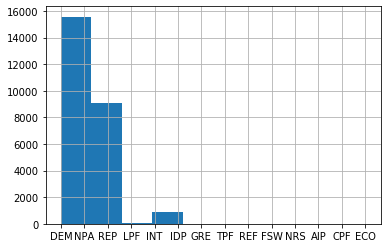

In [124]:
polarized_couples['party_affiliation_male'].hist()

In [125]:
type(polarized_couples)

pandas.core.frame.DataFrame

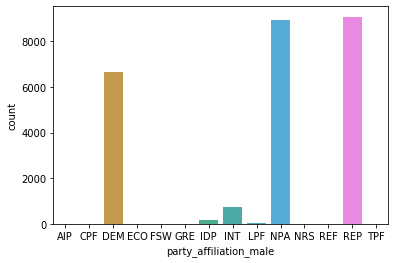

In [126]:
figs, axes = plt.subplots(nrows=1, ncols=1)
sns.barplot(x='party_affiliation_male', y='count', data=polarized_couples.groupby(['party_affiliation_male'])['first_name_male'].agg(['count']).reset_index())

In [133]:
global_df.shape

(1367975, 20)

In [128]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr,member_count
0,DAD,100012467,brummitt,marilyn,421 nw 150th st,,miami,33168,F,5,04/12/1950,11/05/1975,REP,131.0,ACT,69,33168,,421 nw 150th st miami 33168,1
1,DAD,100014823,westervelt,erna,11041 sw 124th st,,miami,33176,F,5,01/16/1923,02/10/1972,REP,756.0,ACT,96,33176,,11041 sw 124th st miami 33176,1
2,DAD,100021401,chang,zoila,11047 nw 3rd ter,,sweetwater,33172,F,5,06/27/1946,01/21/1976,REP,410.0,ACT,73,33172,,11047 nw 3rd ter sweetwater 33172,1
3,DAD,100021484,harris,roberta,15605 sw 57th ln,,miami,33193,F,5,05/22/1938,01/23/1976,REP,764.0,ACT,81,33193,,15605 sw 57th ln miami 33193,1
4,DAD,100024033,guillermety,carmen,10951 sw 161st pl,,miami,33196,F,5,12/28/1916,08/02/1976,REP,766.0,ACT,102,33196,,10951 sw 161st pl miami 33196,2


In [129]:
aggregated_df.head()

,uniq_addr,last_name,member_count
0,1 adams ky islandia 33035,stephens,1
1,1 alhambra cir coral gables 33134,calvillo,1
2,1 alhambra cir 205 coral gables 33134,yngerto,1
3,1 alhambra cir 302 coral gables 33134,menendez palacios,1
4,1 alhambra cir 303 coral gables 33134,morales,1


In [130]:
# global_df['uniq_addr'] = global_df[[]]

In [131]:
last_name_counts = global_df.last_name.value_counts().to_dict()
last_names = set([name for name in last_name_counts if last_name_counts[name] > 1])

In [132]:
aggregated_df = global_df.groupby(['uniq_addr', 'last_name']).agg(['count']).reset_index()
aggregated_df.columns = [' '.join(col).strip() for col in aggregated_df.columns.values]

In [154]:
aggregated_df.head()

,uniq_addr,last_name,county_code count,voter_id count,first_name count,middle_name count,residence_addr_line_1 count,residence_addr_line_2 count,residence_city count,residence_state count,...,race count,birth_date count,registration_date count,party_affiliation count,precinct count,voter_status count,email_address count,age count,residence_zipcode_5 count,residence_zipcode_4 count
0,1 alhambra cir 201 coral gables 33134,gonzalez del campo,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1 alhambra cir 303 coral gables 33134,morales,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1 alhambra cir 306 coral gables 33134,hevia,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1 alhambra cir 405 coral gables 33134,paul,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1 alhambra cir 406 coral gables 33134,salup mosquera,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [155]:
aggregated_df[aggregated_df['first_name count'] == 1].shape

(633397, 22)

In [156]:
global_df.shape

(941446, 22)

In [88]:
lower_age_threshold = 30
upper_age_threshold = 50
global_df = global_df[(global_df['age'] >= lower_age_threshold) & (global_df['age'] <= upper_age_threshold)]

In [89]:
sibling_age_threshold = 30

In [90]:
global_df.shape

(503667, 17)

In [91]:
temp = global_df.groupby(['last_name', 'residence_addr_line_1', 'residence_city', 'residence_zipcode']).agg(['count']).reset_index()

In [92]:
temp.columns = [' '.join(col).strip() for col in temp.columns.values]

In [93]:
temp.columns

Index(['last_name', 'residence_addr_line_1', 'residence_city',
       'residence_zipcode', 'county_code count', 'voter_id count',
       'first_name count', 'residence_addr_line_2 count',
       'residence_state count', 'gender count', 'race count',
       'birth_date count', 'registration_date count',
       'party_affiliation count', 'precinct count', 'voter_status count',
       'age count'],
      dtype='object')

In [94]:
temp[temp['first_name count'] == 1].shape

(438946, 17)

In [95]:
temp.shape

(470610, 17)

In [98]:
global_df[global_df['residence_addr_line_1'] == ''].shape

(0, 17)

In [179]:
# c = pd.DataFrame({"c": global_df['residence_addr_line_1'].apply(lambda x: re.sub("[^0-9a-zA-Z\s]+", '', x))})

(89508, 2)

(142846, 2)

In [160]:
t1 = global_df['last_name'].value_counts()

In [164]:
a = global_df.groupby(['last_name'])['last_name'].agg(['count']).reset_index()

In [168]:
a.shape

(142846, 2)

In [176]:
a[a['count'] > 1].shape

(53338, 2)

In [170]:
b = global_df.groupby(['residence_addr_line_1'])['residence_addr_line_1'].agg(['count']).reset_index()

In [171]:
b.head()

,residence_addr_line_1,count
0,1 alhambra cir,31
1,1 andalusia ave,139
2,1 arvida pkwy,2
3,1 casuarina concourse,1
4,1 century ln,32


In [172]:
b.sort_values(by='count', ascending=False)

,residence_addr_line_1,count
204996,2700 nw 87th ave,2920
205042,2700 d nw 87th ave,1310
52301,1231 dickinson dr,454
164258,19800 sw 180th ave,440
155095,1900 n bayshore dr,424
...,...,...
176865,2111 ne 210th st,1
176868,2111 ne 212th st,1
176869,2111 ne 37th rd,1
176871,2111 ne 40th ave,1


In [173]:
b[b['count'] == 1].shape

(169775, 2)

In [159]:
global_df['residence_addr_line_1'].value_counts()

2700  nw 87th ave  doral 33172                 2919
2700 d nw 87th ave  doral 33172                1306
2700 c nw 87th ave  doral 33172                 420
2700 f nw 87th ave  doral 33172                 412
15800  nw 42nd ave  miami gardens 33054         300
                                               ... 
701   swan ave  miami springs 33166               1
1017  nw 132nd ave w  miami 33182                 1
7929   west dr apt 1002 n bay village 33141       1
13218  nw 4th ter  miami 33182                    1
7730   camino real f108 miami 33143               1
Name: uniq_addr, Length: 584212, dtype: int64

In [174]:
b.shape

(376643, 2)